# TODO LIST

1. Implement the new state encoding for multiple agents;
2. Implement shipyard policy from `predict_reward`;
3. Try to run the multiple agents training for a random policy of the shipyard;
4. Implement the framework to train the shipyard (memory buffer + regression);
5. Use some higher level interface for the learning of the two classes, that allows more clarity and concision and also set up things so that the training can be done with continuity through multiple sessions (because it is likely that it will take several days to get a good result);
6. Tune the learning parameters (epochs, batches, learning rate and so on...);
7. Do a time profiling of the learning procedure to understand where is the bottleneck;
8. Optimize all the implementations by tackilng the bottlenecks.

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../Environment/")
import halite_env as Env
from sklearn.preprocessing import PolynomialFeatures
import encode as cod
import ship
import shipy
from importlib import reload

In [3]:
reload(ship)
reload(shipy)

<module 'shipy' from '/home/nicola/Nicola_unipd/QuartoAnno/TODO/Baiesi/RL/haliteRL/Tabular_methods/shipy.py'>

In [4]:
#@@@@@@@@@@@@@@@@@@@@@@
# Environment variables
#@@@@@@@@@@@@@@@@@@@@@@
NUM_PLAYERS = 1
MAP_SIZE = 7 # 7 x 7 map
TOT_TURNS = 400 # number of turns for each episode

#@@@@@@@@@@@@@@@@
# State variables
#@@@@@@@@@@@@@@@@
H_LEV = 3 # halite levels
N_CELLS = MAP_SIZE**2 # number of cells in a square map
N_ACTIONS = 5 # no dropoffs, 1 action for staying still, 4 for moving in the cardinal directions
N_STATES = N_CELLS*H_LEV**6*(N_ACTIONS-1)*N_ACTIONS
print("Total number of states to be experienced: ", N_STATES)

#@@@@@@@@@@@@@@@@@@@@
# Learning parameters
#@@@@@@@@@@@@@@@@@@@@
#N_BATCH = 50 #100 # number of episodes in an epoch
#MAX_EPOCHS = 300 # max number of epochs played before stopping (500 ~ 7.3 hours of training)
DISCOUNT_FACTOR = 1 - 1/TOT_TURNS #train ships as if each turn has a probability of 1/tot_turns of ending the game 
STD_REWARD = -0.01
LEARNING_RATE = 0.1

Total number of states to be experienced:  714420


Interesting variables to observe during the ships training:
- halite collected
- total number of ship spawned
- total number of shipwrecks (can be represented in the same panel of the spawned ships)
- number of passages through the shipyard
- epsilon

In [5]:
def multi_ship_agent_training_v1(q_values, weights, shipy_eps = 0, show = True, N_BATCH = 20, MAX_EPOCHS = 300):
    
    halite_score = np.zeros(MAX_EPOCHS)
    ship_score = np.zeros(MAX_EPOCHS)
    shipwreck_score = np.zeros(MAX_EPOCHS)
    passages_score = np.zeros(MAX_EPOCHS)
    epochs = 0
    
    if show:
        # visualize online the results
        %matplotlib notebook
        fig = plt.figure(figsize = (8,6))
        plt.ion()

        ax1 = fig.add_subplot(221)
        ax1.set_xlim(0,MAX_EPOCHS+1)
        #ax1.set_ylim(0,8000)
        ax1.set_xlabel("Epochs", fontsize = 14)
        ax1.set_ylabel("Halite collected", fontsize = 14)

        ax2 = fig.add_subplot(222)
        ax2.set_xlim(0,MAX_EPOCHS+1)
        #ax2.set_ylim(-4,4)
        ax2.set_xlabel("Epochs", fontsize = 14)
        ax2.set_ylabel("Ships and shipwrecks", fontsize = 14)


        ax3 = fig.add_subplot(223)
        ax3.set_xlim(0,MAX_EPOCHS+1)
        ax3.set_ylim(0,0.5)
        ax3.set_xlabel("Epochs", fontsize = 14)
        ax3.set_ylabel("Epsilon", fontsize = 14)


        ax4 = fig.add_subplot(224)
        ax4.set_xlim(0,MAX_EPOCHS+1)
        ax4.set_xlabel("Epochs", fontsize = 14)
        ax4.set_ylabel("Shipyard passages", fontsize = 14)

        plt.tight_layout()
        fig.show()
        fig.canvas.draw()

    from tqdm import tnrange

    for k in tnrange(MAX_EPOCHS):
        #@@@@@@@@@@@@@@@@@@@@@@
        # here starts an epoch
        #@@@@@@@@@@@@@@@@@@@@@@
        epochs = epochs + 1
        
        # bunch of N_BATCH episodes
        halite_progress = np.zeros(N_BATCH) 
        ship_progress = np.zeros(N_BATCH)
        shipwreck_progress = np.zeros(N_BATCH)
        passages_progress = np.zeros(N_BATCH)
        
        eps = 0.5 # starting value of epsilon
        # generate an adaptive epsilon greedy algorithm, calibrated in order to have epsilon = 10^-4 at the last epoch
        epsilons = np.array(list(map(lambda i : eps*np.exp(-i*2*np.log(10)/MAX_EPOCHS), np.arange(0,MAX_EPOCHS+1))))

        for i in range(N_BATCH):
            #@@@@@@@@@@@@@@@@@@@@@@@@
            # here starts an episode
            #@@@@@@@@@@@@@@@@@@@@@@@@
            env = Env.HaliteEnv(NUM_PLAYERS, MAP_SIZE, episode_lenght = TOT_TURNS) # init environment
            steps = 0
            
            ship_count = 0
            shipwreck_count = 0
            passages_count = 0
            
            # first mandatory step
            steps = steps + 1
            #print("\nStep number %d:"%steps)
            action_matrix = np.full((MAP_SIZE,MAP_SIZE), -1) # no ship, no action
            shipyard_action = 1 # initially always choose to create a ship
            ship_count += shipyard_action
            # returns the matricial state, the array of players halite and a flag that is true if it's the final turn
            state, players_halite, finish, _ = env.step(action_matrix, makeship = shipyard_action) 
            #print("Ship labels: \n", state[:,:,4])
            current_halite = players_halite[0][0]
            encoded_states = cod.encode_multi_state(state, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS, debug=False)
            encoded_states = np.array(encoded_states)
            current_ship_ids = state[:,:,4][state[:,:,1].astype(bool)]
            #print("Initial ship IDs: ", current_ship_ids)
            
            while True:
                steps = steps + 1
                #print("\nStep number %d:"%steps)
                #print("Current halite: ", current_halite)
                actions = []
                for j in range(len(encoded_states)):
                    a_enc = ship.e_greedy_policy(encoded_states[j], q_values, eps = epsilons[epochs])
                    actions.append(a_enc)
                a_mat = cod.multi_scalar_to_matrix_action(actions, state, map_size = MAP_SIZE)

                shipyard_action = shipy.shipy_policy(weights, state, current_halite, steps, epsilon = shipy_eps,
                                               tot_turns = TOT_TURNS, map_size = MAP_SIZE)
                ship_count += shipyard_action
                
                # submit the action and get the new state
                state, players_halite, finish, _ = env.step(a_mat, makeship = shipyard_action) 
                #print("Ship labels: \n", state[:,:,4])
                new_halite = players_halite[0][0]
                #print("New halite: ", new_halite)
                new_ship_ids = state[:,:,4][state[:,:,1].astype(bool)]
                #print("New ships IDs: ", new_ship_ids)
                new_encoded_states = cod.encode_multi_state(state, map_size = 7, h_lev = 3,
                                                            n_actions = 5, debug = False)
                new_encoded_states = np.array(new_encoded_states)
                
                rewards = [] # rewards are stored following the position order
                for j in range(len(current_ship_ids)):
                    if current_ship_ids[j] not in new_ship_ids:
                        r = -1 + STD_REWARD*(TOT_TURNS-steps)
                        shipwreck_count += 1
                    else:
                        mask = (new_ship_ids == current_ship_ids[j])
                        sp_dec = cod.decode4D(new_encoded_states[mask], 
                                              L1 = N_CELLS, L2 = H_LEV**6, L3 = N_ACTIONS-1, L4 = N_ACTIONS)
                        shipy_pos = (N_CELLS-1)/2 #shipyard is at the center of the map
                        if sp_dec[0] == shipy_pos:
                            r = (new_halite - current_halite)/1000 + STD_REWARD
                            passages_count += 1
                        else:
                            r = STD_REWARD
                    rewards.append(r)

                for j in range(len(encoded_states)):
                    s_enc = encoded_states[j]
                    a_enc = actions[j]
                    r = rewards[j]
                    if current_ship_ids[j] in new_ship_ids:
                        # simulate the best action in the new state (before update)
                        mask = (new_ship_ids == current_ship_ids[j])
                        #print("Mask: ", mask)
                        #print("new_encoded_states: ", new_encoded_states)
                        sp_enc = new_encoded_states[mask]
                        a_temp_enc = ship.greedy_policy(sp_enc, q_values) 
                        # update Q-values
                        q_values = ship.update_q_v2(s_enc, a_enc, r, sp_enc, a_temp_enc, q_values, 
                                               gamma = DISCOUNT_FACTOR, n_cells = N_CELLS, h_lev = H_LEV, 
                                               n_actions = N_ACTIONS, alpha = LEARNING_RATE)
                    else:
                        q_values[s_enc,a_enc] = (1-LEARNING_RATE)*q_values[s_enc,a_enc] + LEARNING_RATE*r 
                    
                # update states and halite
                encoded_states = new_encoded_states
                current_halite = new_halite
                current_ship_ids = new_ship_ids
                # TO DO: case in which 2 or more ships crash

                if (finish == True) or (steps >= 400):
                    #print("End episode.")
                    halite_progress[i] = current_halite - 4000
                    ship_progress[i] = ship_count
                    shipwreck_progress[i] = shipwreck_count
                    passages_progress[i] = passages_count
                    
                    break
            #break # play just 1 episode

        #break # play just 1 epoch

        halite_score[epochs-1] = halite_progress.mean()
        ship_score[epochs-1] = ship_progress.mean()
        shipwreck_score[epochs-1] = shipwreck_progress.mean()
        passages_score[epochs-1] = passages_progress.mean()

        if show:
            ax1.scatter(epochs, halite_score[epochs-1], s = 10, color='blue')
            ax2.scatter(epochs, ship_score[epochs-1], s = 10,color='blue')
            ax2.scatter(epochs, shipwreck_score[epochs-1], s = 10,color='red')
            ax3.scatter(epochs, epsilons[epochs], s = 10, color='blue')
            ax4.scatter(epochs, passages_score[epochs-1], s = 10, color='blue')
            fig.canvas.draw()
        else:
            #print("Average reward per episode in epoch %d: %.3f"%(epochs, reward_progress.mean()))
            print("Average halite collected per episode in epoch %d: %.3f"%(epochs,halite_progress.mean()))
            print("Espilon value: %.4f \n"%epsilons[epochs])

        if epochs >= MAX_EPOCHS:
            print("Hey, I think you've had enough! Let's stop here.")
            break
    return q_values, halite_score, ship_score, shipwreck_score, passages_score

Interesting variables to observe during the ships training:
- halite collected
- epsilon
- score of the fit
- number of ship spawned

In [6]:
def shipyard_training_v1(q_values, weights, ship_eps = 0, show = True, N_BATCH = 20, MAX_EPOCHS = 300):
    
    halite_score = np.zeros(MAX_EPOCHS)
    ship_score = np.zeros(MAX_EPOCHS)
    fit_score = np.zeros(MAX_EPOCHS)
    
    shipy_progress = []
    epochs = 0
    
    if show:
        # visualize online the results
        %matplotlib notebook
        fig = plt.figure(figsize = (8,6))
        plt.ion()

        ax1 = fig.add_subplot(221)
        ax1.set_xlim(0,MAX_EPOCHS+1)
        #ax1.set_ylim(0,8000)
        ax1.set_xlabel("Epochs", fontsize = 14)
        ax1.set_ylabel("Halite collected", fontsize = 14)

        ax2 = fig.add_subplot(222)
        ax2.set_xlim(0,MAX_EPOCHS+1)
        #ax2.set_ylim(-4,4)
        ax2.set_xlabel("Epochs", fontsize = 14)
        ax2.set_ylabel("Ships spawned", fontsize = 14)


        ax3 = fig.add_subplot(223)
        ax3.set_xlim(0,MAX_EPOCHS+1)
        ax3.set_ylim(0,0.5)
        ax3.set_xlabel("Epochs", fontsize = 14)
        ax3.set_ylabel("Epsilon", fontsize = 14)


        ax4 = fig.add_subplot(224)
        ax4.set_xlim(0,MAX_EPOCHS+1)
        ax4.set_xlabel("Epochs", fontsize = 14)
        ax4.set_ylabel("Fit score", fontsize = 14)

        plt.tight_layout()
        fig.show()
        fig.canvas.draw()


    from tqdm import tnrange

    for k in tnrange(MAX_EPOCHS):
        #@@@@@@@@@@@@@@@@@@@@@@
        # here starts an epoch
        #@@@@@@@@@@@@@@@@@@@@@@
        epochs = epochs + 1
        halite_progress = np.zeros(N_BATCH) # bunch of 100 episodes
        ship_progress = np.zeros(MAX_EPOCHS)
        fit_progress = np.zeros(MAX_EPOCHS)
        #episode_progress = []
        eps = 0.5 # starting value of epsilon
        # generate an adaptive epsilon greedy algorithm, calibrated in order to have epsilon = 10^-4 at the last epoch
        epsilons = np.array(list(map(lambda i : eps*np.exp(-i*2*np.log(10)/MAX_EPOCHS), np.arange(0,MAX_EPOCHS+1))))

        for i in range(N_BATCH):
            #@@@@@@@@@@@@@@@@@@@@@@@@
            # here starts an episode
            #@@@@@@@@@@@@@@@@@@@@@@@@
            env = Env.HaliteEnv(NUM_PLAYERS, MAP_SIZE, episode_lenght = TOT_TURNS) # init environment
            steps = 0
            ship_count = 0
            episode_trajectory = []

            # first mandatory step
            steps = steps + 1
            action_matrix = np.full((MAP_SIZE,MAP_SIZE), -1) # no ship, no action
            shipyard_action = 1 # initially always choose to create a ship
            ship_count += shipyard_action
            # returns the matricial state, the array of players halite and a flag that is true if it's the final turn
            n_ships = 0
            t_left = TOT_TURNS - steps
            h_tot = 5000
            near_ships = 0
            episode_trajectory.append([n_ships, t_left, h_tot, near_ships])
            state, players_halite, finish, _ = env.step(action_matrix, makeship = shipyard_action) 
            current_halite = players_halite[0][0]
            encoded_states = cod.encode_multi_state(state, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS, debug=False)
            encoded_states = np.array(encoded_states)
            
            
            while True:
                steps = steps + 1
                actions = []
                for j in range(len(encoded_states)):
                    a_enc = ship.greedy_policy(encoded_states[j], q_values)
                    actions.append(a_enc)
                a_mat = cod.multi_scalar_to_matrix_action(actions, state, map_size = MAP_SIZE)

                shipyard_action = shipy.shipy_policy(weights, state, current_halite, steps, epsilon = epsilons[epochs],
                                               tot_turns = TOT_TURNS, map_size = MAP_SIZE)
                ship_count += shipyard_action
                if shipyard_action == True:
                    episode_trajectory.append(shipy.get_shipy_state(state, h_tot, steps, tot_turns = TOT_TURNS, map_size = MAP_SIZE))
                
                state, players_halite, finish, _ = env.step(a_mat, makeship = shipyard_action) 
                current_halite = players_halite[0][0]
                encoded_states = cod.encode_multi_state(state, map_size = 7, h_lev = 3,
                                                            n_actions = 5, debug = False)

                if (finish == True) or (steps >= 400):
                    #print("End episode.")
                    halite_progress[i] = current_halite - 4000
                    ship_progress[i] = ship_count
                    episode_trajectory = np.array(episode_trajectory)
                    shipy_progress.append((episode_trajectory, current_halite - 4000))
                    break
            #break # play just 1 episode
        
        # this operations are executed every epoch
        weights, score = shipy.regress(shipy_progress)
        #break # play just 1 epoch

        halite_score[epochs-1] = halite_progress.mean()
        ship_score[epochs-1] = ship_progress.mean()
        fit_score[epochs-1] = score
        
        if show:
            ax1.scatter(epochs, halite_score[epochs-1], s = 10, color='blue')
            ax2.scatter(epochs, ship_score[epochs-1], s = 10,color='blue')
            ax3.scatter(epochs, epsilons[epochs], s = 10, color='blue')
            ax4.scatter(epochs, fit_score[epochs-1], s = 10, color='blue')
            fig.canvas.draw()
        else:
            #print("Average reward per episode in epoch %d: %.3f"%(epochs, reward_progress.mean()))
            print("Average halite collected per episode in epoch %d: %.3f"%(epochs,halite_progress.mean()))
            print("Espilon value: %.4f \n"%epsilons[epochs])

        if epochs >= MAX_EPOCHS:
            print("Hey, I think you've had enough! Let's stop here.")
            break
    return weights, halite_score, ship_score, fit_score

# Simulations

In [7]:
#@@@@@@@@@@@@@@@
# Initialization
#@@@@@@@@@@@@@@@

q_values = np.zeros((N_STATES,N_ACTIONS)) #initialize to zero

from sklearn.preprocessing import PolynomialFeatures
SHIPY_FEATURES = 4
w_len = int((SHIPY_FEATURES+1)*(SHIPY_FEATURES+2)/2)
print("Number of parameters for the shipyard policy: ", w_len)

sigmas = np.array([1/N_CELLS, 1/TOT_TURNS, 1/5000, 1/5]) # inverse of the maximum/initial values of each feature

poly = PolynomialFeatures(2)
poly_sigmas = poly.fit_transform(sigmas.reshape(1,-1))[0]
weights = np.random.normal(scale = poly_sigmas) # random initial weights
print("Initial random weights: \n", weights)

Number of parameters for the shipyard policy:  15
Initial random weights: 
 [-4.78024486e-01  8.52010139e-03  1.52701924e-04  2.63035134e-04
 -2.73058974e-02  2.16521463e-04  7.31736774e-05  2.59332143e-06
 -1.03934849e-03 -8.25867231e-06  5.96592473e-07 -3.03581293e-04
  7.16769160e-08  1.98933306e-05  4.32748589e-02]


<IPython.core.display.Javascript object>


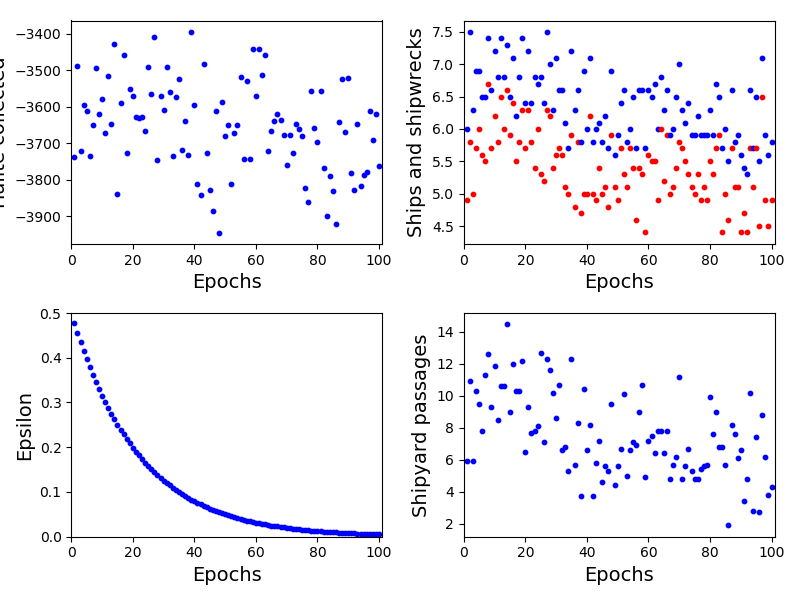

Hey, I think you've had enough! Let's stop here.


In [36]:
SHIPY_EPS = 0.5 # shipyard policy not trained, thus we use a total random policy
result = multi_ship_agent_training_v1(q_values, weights, shipy_eps = SHIPY_EPS, 
                                        show = True, N_BATCH = 20, MAX_EPOCHS = 100)
q_values, halite_score1, ship_score1, shipwreck_score1, passages_score1 = result
np.save("multi_Q_values_1", q_values) 
np.save("halite_score1", halite_score1) 
np.save("ship_score1", ship_score1) 
np.save("shipwreck_score1", shipwreck_score1) 
np.save("passages_score1", passages_score1) 

<IPython.core.display.Javascript object>


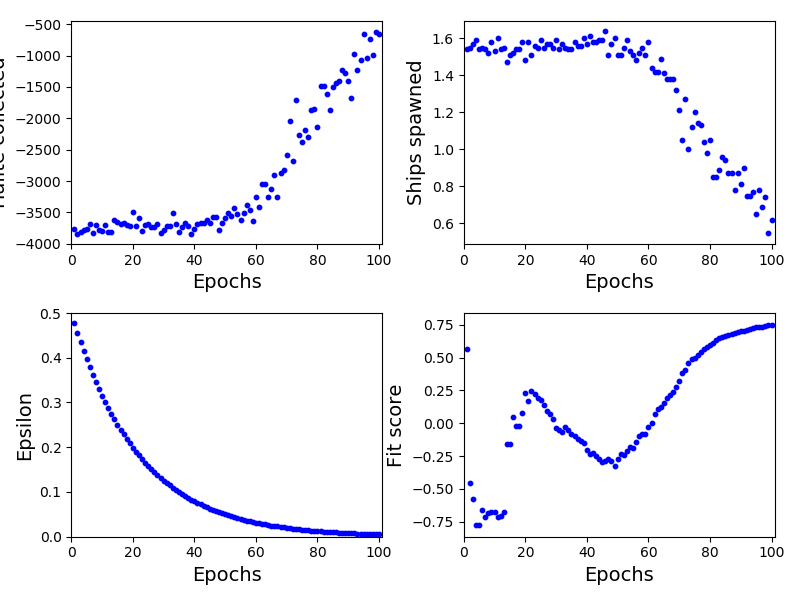

Hey, I think you've had enough! Let's stop here.


In [37]:
SHIP_EPS = 0 # ship class already trained, thus we use greedy policy
result = shipyard_training_v1(q_values, weights, SHIP_EPS, show = True, N_BATCH = 30, MAX_EPOCHS = 100)
weights, halite_score, ship_score, fit_score = result
np.save("weights_1", weights)

In [ ]:
q_values = np.load("multi_Q_values_1.npy")
weights =  np.load("weights_1.npy")
SHIPY_EPS = 0.1 # eps-greedy policy for the shipyard
result = multi_ship_agent_training_v1(q_values, weights, shipy_eps = SHIPY_EPS, 
                                        show = True, N_BATCH = 10, MAX_EPOCHS = 100)
q_values, halite_score2, ship_score2, shipwreck_score2, passages_score2 = result
np.save("multi_Q_values_2", q_values)
np.save("halite_score2", halite_score2)
np.save("ship_score2", ship_score2)
np.save("shipwreck_score2" shipwreck_score2)
np.save("passages_score2" passages_score2)

<IPython.core.display.Javascript object>


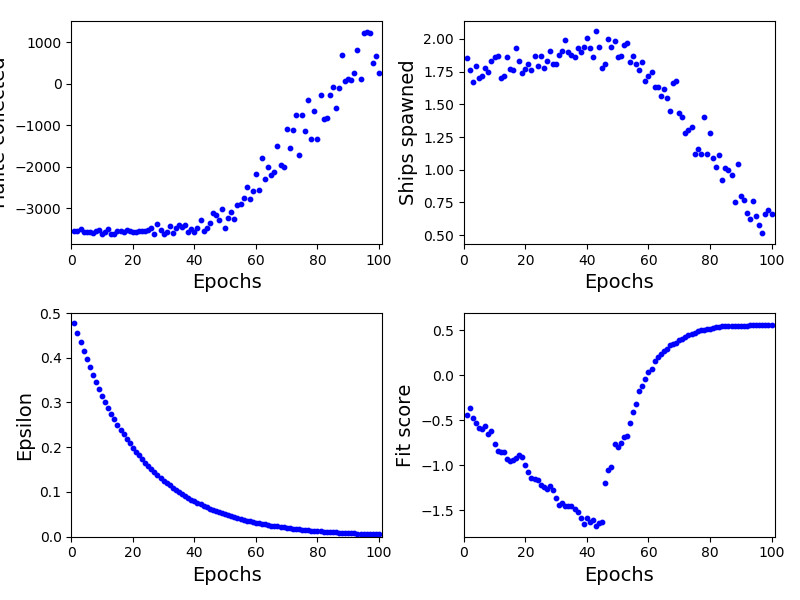

Hey, I think you've had enough! Let's stop here.


In [40]:
q_values = np.load("multi_Q_values_2.npy")
weights =  np.load("weights_1.npy")
SHIP_EPS = 0 # ship class already trained, thus we use greedy policy
result = shipyard_training_v1(q_values, weights, SHIP_EPS, show = True, N_BATCH = 30, MAX_EPOCHS = 100)
weights, halite_score3, ship_score3, fit_score3 = result
np.save("weights_2", weights)